## dask <code>compute()</code> Deferred Computing

We're going to build a somewhat interesting workload and then run it a couple of different ways.  Let's start by loading the NYC flight data.

This exercise will reinforce dask dataframe programming concepts by building a set of analyses. We will then use these type of `groupby` and aggregate queries to look at execution properties.

Code that you need to write is indicated with #TODO. I've left the output of the reference implementation in the cells so that you can refer to it for correctness.  You can refer to the read-only shared version for this output.

In [1]:
%pip install fsspec
%pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Read in the NYC Flights data from Google cloud storage and then print the dataframe metadata.

In [2]:
import dask.dataframe as dd

df = dd.read_csv('gcs://nycflights/*.csv',
                 storage_options={'token': 'anon'},
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Let's build a set of queries around the performance of particular planes, identified by tail number.  The pattern will be to <code>groupby('TailNum') and then compute statistics.

__Query__: What is the average departure delay 'DepDelay' for each plane?

In [16]:
#TODO
df_delay = df.groupby('TailNum')['DepDelay'].mean()
delay = df_delay.compute()
print(delay.max())
delay

241.0


TailNum
EI-BWD    11.213501
EI-CAL    23.846154
EI-CAM    26.611511
EI-CIW    12.918182
N050AA     9.180180
            ...    
N976TW    -2.294118
N978TW     0.000000
N979TW     5.250000
N980TW     3.428571
N982TW    14.000000
Name: DepDelay, Length: 3712, dtype: float64

Interesting, some planes were early, lets plot a histrogram of the distribution with 1000 bins.

/usr/local/lib/python3.7/dist-packages/dask/array/core.py:1645: FutureWarning: The `numpy.size` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


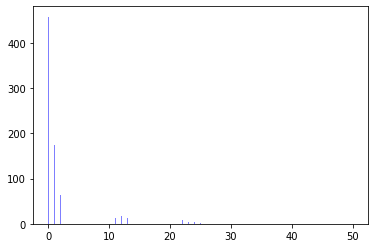

In [20]:
import seaborn as sns
import dask.array as da
import matplotlib.pyplot as plt

%matplotlib inline
h, bins = da.histogram(df_delay, bins=1000,range=[0,50])
n, bins, patches = plt.hist(h, bins, facecolor='blue', alpha=0.5)
plt.show()


OK, we have very few chronically bad planes.  Let's find those that are 30 (or more) minutes late on average.

In [31]:
import numpy as np 
lateplanes = delay.loc[lambda x : x > 30].index.to_numpy()


print(np.sort(lateplanes))

['N101UW' 'N102UW' 'N104UW' 'N106UW' 'N133JC' 'N133TW' 'N134TW' 'N14249'
 'N144JC' 'N147US' 'N151AW' 'N151UA' 'N152UA' 'N153US' 'N154AA' 'N154AW'
 'N155US' 'N156AW' 'N158AW' 'N161US' 'N168AW' 'N169AW' 'N17010' 'N17011'
 'N1738D' 'N1739D' 'N174AW' 'N174GM' 'N174UA' 'N175UA' 'N17789' 'N1854U'
 'N195UA' 'N199UA' 'N224DA' 'N224NW' 'N225NW' 'N235NW' 'N303TW' 'N304AW'
 'N305AW' 'N305TW' 'N307TW' 'N322AW' 'N328AW' 'N33021' 'N3310L' 'N331AW'
 'N375DA' 'N376DL' 'N379DL' 'N382DA' 'N53110' 'N53116' 'N534TW' 'N6700'
 'N701UW' 'N706UW' 'N708UW' 'N713DA' 'N713UW' 'N716DA' 'N719DA' 'N724DA'
 'N727UW' 'N733DS' 'N735D' 'N737D' 'N760DH' 'N78019' 'N787DL' 'N789DL'
 'N802DE' 'N805DE' 'N817AA' 'N8911E' 'N93104' 'N93107' 'N93108' 'N93109'
 'N93119' 'N96S' 'N971Z' 'N976UA' 'N993UA' 'NEIDLA' 'UNKNOW']


OK, this is a hard query.
Build a dataframe that is a subset all the data associated with the late planes.  There are many ways to solve this problem. I would recommend looking at the `isin()` function in dask.

In [34]:
df_late = df.loc[df['TailNum'].isin(lateplanes),:]
df_late

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
8,1995-01-09,1,NaN,1950,NaN,2337,CO,401,UNKNOW,NaN,...,42.0,NaN,NaN,EWR,PHX,2133.0,8.0,33.0,True,0
39,1995-01-18,3,NaN,1640,NaN,2002,CO,446,UNKNOW,NaN,...,56.0,NaN,NaN,EWR,PHX,2133.0,6.0,20.0,True,0
248,1995-01-11,3,NaN,1815,NaN,2202,TW,731,UNKNOW,NaN,...,124.0,NaN,NaN,JFK,PHX,2153.0,10.0,34.0,True,0
276,1995-01-09,1,NaN,1900,NaN,2042,CO,633,UNKNOW,NaN,...,134.0,NaN,NaN,EWR,PIT,319.0,5.0,18.0,True,0
285,1995-01-09,1,NaN,1500,NaN,1634,CO,663,UNKNOW,NaN,...,154.0,NaN,NaN,EWR,PIT,319.0,4.0,11.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268926,1999-12-20,1,NaN,1846,NaN,2103,UA,1609,UNKNOW,NaN,...,NaN,NaN,NaN,EWR,DEN,1605.0,0.0,0.0,True,0
269031,1999-12-16,4,NaN,615,NaN,829,UA,401,UNKNOW,NaN,...,NaN,NaN,NaN,LGA,DEN,1619.0,0.0,0.0,True,0
269093,1999-12-14,2,NaN,1650,NaN,1906,UA,785,UNKNOW,NaN,...,NaN,NaN,NaN,LGA,DEN,1619.0,0.0,0.0,True,0
269153,1999-12-17,5,NaN,1400,NaN,1613,UA,1691,UNKNOW,NaN,...,NaN,NaN,NaN,LGA,DEN,1619.0,0.0,0.0,True,0


Double check that the planes indexes match.

In [37]:
import numpy as np 
latelist = df_late['TailNum'].unique()
print(np.sort(latelist))

['N101UW' 'N102UW' 'N104UW' 'N106UW' 'N133JC' 'N133TW' 'N134TW' 'N14249'
 'N144JC' 'N147US' 'N151AW' 'N151UA' 'N152UA' 'N153US' 'N154AA' 'N154AW'
 'N155US' 'N156AW' 'N158AW' 'N161US' 'N168AW' 'N169AW' 'N17010' 'N17011'
 'N1738D' 'N1739D' 'N174AW' 'N174GM' 'N174UA' 'N175UA' 'N17789' 'N1854U'
 'N195UA' 'N199UA' 'N224DA' 'N224NW' 'N225NW' 'N235NW' 'N303TW' 'N304AW'
 'N305AW' 'N305TW' 'N307TW' 'N322AW' 'N328AW' 'N33021' 'N3310L' 'N331AW'
 'N375DA' 'N376DL' 'N379DL' 'N382DA' 'N53110' 'N53116' 'N534TW' 'N6700'
 'N701UW' 'N706UW' 'N708UW' 'N713DA' 'N713UW' 'N716DA' 'N719DA' 'N724DA'
 'N727UW' 'N733DS' 'N735D' 'N737D' 'N760DH' 'N78019' 'N787DL' 'N789DL'
 'N802DE' 'N805DE' 'N817AA' 'N8911E' 'N93104' 'N93107' 'N93108' 'N93109'
 'N93119' 'N96S' 'N971Z' 'N976UA' 'N993UA' 'NEIDLA' 'UNKNOW']


Now, let's get a sense of what airports these planes fly out of.  For the planes in the late_list, let's find out the total delay at these airports, the average delay by airport and the total number of flights at each airport.

In [40]:
#TODO total DepDelay for planes by Origin airport
df_late.groupby("Origin")["DepDelay"].sum().compute()

Origin
EWR    16982.0
JFK    61684.0
LGA    27669.0
Name: DepDelay, dtype: float64

In [41]:
#TODO average DepDelay for planes by Origin airport
df_late.groupby("Origin")["DepDelay"].mean().compute()

Origin
EWR    43.101523
JFK    41.763033
LGA    36.027344
Name: DepDelay, dtype: float64

In [42]:
#TODO number of late flights by Origin airport
df_late.groupby("Origin")["DepDelay"].count().compute()

Origin
EWR     394
JFK    1477
LGA     768
Name: DepDelay, dtype: int64

I don't know that these statistics all make sense, but that's to debug.

## Deferred computing

We are going to show the value of deferred computation by timing the following
queries in two different ways:

```python
df1 = df.groupby(['Origin','TailNum']).DepDelay.mean()
df2 = df.groupby(['TailNum','Origin']).DepDelay.mean()
df3 = df.groupby(['Origin','TailNum']).DepDelay.max()
df4 = df.groupby(['TailNum','Origin']).DepDelay.max()
```

 1. In one cell, add these lines and then call `compute()` on every step.
 2. In the next cell, add the lines and only call compute at the end.

 First reload the data:

In [ ]:
import dask.dataframe as dd
df = dd.read_csv('gs://nycflights/*.csv',
                 storage_options={'token': 'anon'},
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

Run the workload calling `compute()` on every line.

In [43]:
%%time

#TODO
df1 = df.groupby(['Origin','TailNum']).DepDelay.mean().compute()
df2 = df.groupby(['TailNum','Origin']).DepDelay.mean().compute()
df3 = df.groupby(['Origin','TailNum']).DepDelay.max().compute()
df4 = df.groupby(['TailNum','Origin']).DepDelay.max().compute()

CPU times: user 24.2 s, sys: 2.23 s, total: 26.4 s
Wall time: 21 s


Load the data again to make sure that intermediate results are not cached and run the entire workload calling `compute()` just once.

In [48]:
import dask.dataframe as dd
df = dd.read_csv('gs://nycflights/*.csv',
                 storage_options={'token': 'anon'},
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [51]:

%%time

import dask

df1 = df.groupby(['Origin','TailNum']).DepDelay.mean()
df2 = df.groupby(['TailNum','Origin']).DepDelay.mean()
df3 = df.groupby(['Origin','TailNum']).DepDelay.max()
df4 = df.groupby(['TailNum','Origin']).DepDelay.max()

df1,df2,df3,df4 = dask.compute(df1,df2,df3,df4)

#TODO
print(df1)
print(df2)
print(df3)
print(df4)

Origin  TailNum
EWR     EI-BWD      9.355140
        EI-CIW     16.283019
        N050AA      8.309677
        N051AA      5.949275
        N052AA     21.845070
                     ...    
LGA     N993UA     55.000000
        N994UA     -3.250000
        N995UA     14.600000
        N996UA      9.333333
        N998UA      1.750000
Name: DepDelay, Length: 8861, dtype: float64
TailNum  Origin
EI-BWD   EWR        9.355140
         JFK       11.575758
         LGA       11.626866
EI-CAL   JFK       23.846154
EI-CAM   JFK       26.611511
                     ...    
N993UA   LGA       55.000000
N994UA   LGA       -3.250000
N995UA   LGA       14.600000
N996UA   LGA        9.333333
N998UA   LGA        1.750000
Name: DepDelay, Length: 8861, dtype: float64
Origin  TailNum
EWR     EI-BWD     177.0
        EI-CIW     331.0
        N050AA     248.0
        N051AA     140.0
        N052AA     996.0
                   ...  
LGA     N993UA     227.0
        N994UA       0.0
        N995UA      59.0



### Outcomes
* Wrestled with dataframes syntax and concepts.  Good for you.
* Witnessed the benefit of deferred computation.

### Questions

1. On computational reuse in execution graphs:

  a. How much faster is it to defer the computation to the end versus calling `compute()` on every line?


  20 seconds faster.

  b. What computations are shared in the workflow?  Be specific, i.e. identify the code.

  The groupby operation is shared.

  c. Explain the speedup realized in 1(a). Why is it not faster? Why is it not slower?
